In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from joblib import dump

In [26]:
# ----------------- Load datasets -----------------
traffic = pd.read_csv("data/Metro_Interstate_Traffic_Volume.csv")
weather = pd.read_csv("data/Weather_Data.csv")
holidays = pd.read_csv("data/Holidays.csv")
# road_info = pd.read_csv("data/Road_Info.csv")  # optional, not used in merge

In [27]:
# ----------------- Preprocessing -----------------
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
weather['date_time'] = pd.to_datetime(weather['date_time'])
holidays['date'] = pd.to_datetime(holidays['date'])


In [28]:
# Time features
traffic['hour'] = traffic['date_time'].dt.hour
traffic['dayofweek'] = traffic['date_time'].dt.dayofweek
traffic['month'] = traffic['date_time'].dt.month
traffic['day_of_year'] = traffic['date_time'].dt.dayofyear
traffic['is_weekend'] = traffic['dayofweek'].apply(lambda x: 1 if x>=5 else 0)

In [29]:
# Merge traffic with weather (using nearest timestamps)
df = pd.merge_asof(
    traffic.sort_values('date_time'),
    weather.sort_values('date_time'),
    on='date_time',
    direction='nearest',
    tolerance=pd.Timedelta('1H')
)



/var/folders/57/3_v_zw8x4xn3gxk_9881ppw80000gn/T/ipykernel_5800/3646178307.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta('1H')


In [30]:
# Holiday flag
df['is_holiday'] = df['date_time'].dt.date.isin(holidays['date'].dt.date).astype(int)


In [31]:
print(df.columns)


Index(['holiday', 'temp_x', 'rain_1h_x', 'snow_1h', 'clouds_all_x',
       'weather_main_x', 'weather_description_x', 'date_time',
       'traffic_volume', 'hour', 'dayofweek', 'month', 'day_of_year',
       'is_weekend', 'temp_y', 'rain_1h_y', 'clouds_all_y', 'weather_main_y',
       'weather_description_y', 'is_holiday'],
      dtype='object')


In [32]:
df.rename(columns={
    'Temp': 'temp',
    'Rain_1h': 'rain_1h',
    'Clouds_all': 'clouds_all'
}, inplace=True)


In [33]:
print(df.columns.tolist())


['holiday', 'temp_x', 'rain_1h_x', 'snow_1h', 'clouds_all_x', 'weather_main_x', 'weather_description_x', 'date_time', 'traffic_volume', 'hour', 'dayofweek', 'month', 'day_of_year', 'is_weekend', 'temp_y', 'rain_1h_y', 'clouds_all_y', 'weather_main_y', 'weather_description_y', 'is_holiday']


In [34]:
df.rename(columns={
    'temp_y': 'temp',
    'rain_1h_y': 'rain_1h',
    'clouds_all_y': 'clouds_all', 
    'weather_main_y': 'weather_main',
    'weather_description_y': 'weather_description'
}, inplace=True)


In [35]:
for col in ['temp','rain_1h','clouds_all']:
    df[col] = df[col].fillna(df[col].mean())


In [36]:
# Add distance feature (random for demo)
np.random.seed(42)
df['distance'] = np.random.randint(0,51,size=len(df))

# ----------------- FEATURES & TARGET -----------------
features = ['hour','dayofweek','month','day_of_year','is_weekend',
            'temp','rain_1h','clouds_all','is_holiday','distance']
X = df[features]
y = df['traffic_volume']

In [37]:
# ----------------- TRAIN MODEL -----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Mean Absolute Error (MAE): 227.96
Root Mean Squared Error (RMSE): 377.68
R² Score: 0.96


In [17]:
# Save trained model
dump(model, "traffic_model_app_pro.joblib")
print("Model saved as traffic_model_app_pro.joblib")


Model saved as traffic_model_app_pro.joblib


DataFrame shape: (48204, 21)
   temp  traffic_volume
0   NaN            5545
1   NaN            4516
2   NaN            4767
3   NaN            5026
4   NaN            4918
Missing values:
 temp              48204
traffic_volume        0
dtype: int64


/var/folders/57/3_v_zw8x4xn3gxk_9881ppw80000gn/T/ipykernel_5800/2092330787.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='hour', y='traffic_volume', data=df, ci=None, estimator=np.mean)


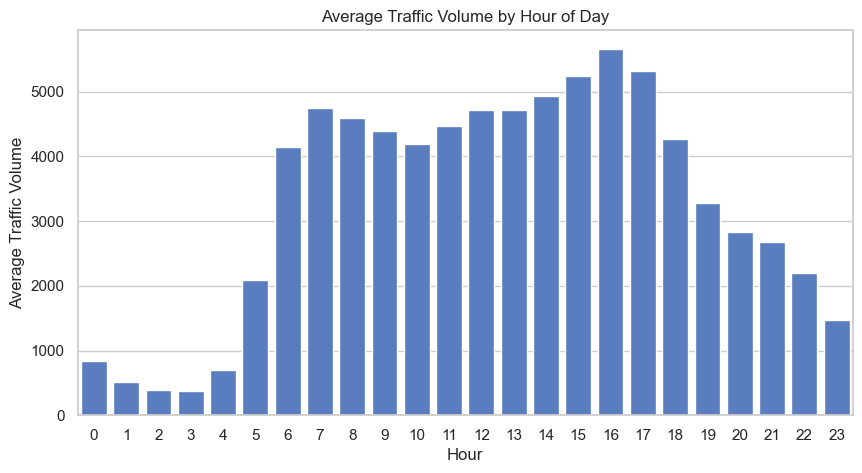

In [18]:
# ----------------- VISUALIZATION -----------------
sns.set(style="whitegrid", palette="muted")
# --- Debug Check ---
print("DataFrame shape:", df.shape)
print(df[['temp', 'traffic_volume']].head())
print("Missing values:\n", df[['temp', 'traffic_volume']].isnull().sum())


# Traffic Volume over Hour of Day
plt.figure(figsize=(10,5))
sns.barplot(x='hour', y='traffic_volume', data=df, ci=None, estimator=np.mean)
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Traffic Volume")
plt.show()

/var/folders/57/3_v_zw8x4xn3gxk_9881ppw80000gn/T/ipykernel_5800/1894708175.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='dayofweek', y='traffic_volume', data=df, ci=None, estimator=np.mean)


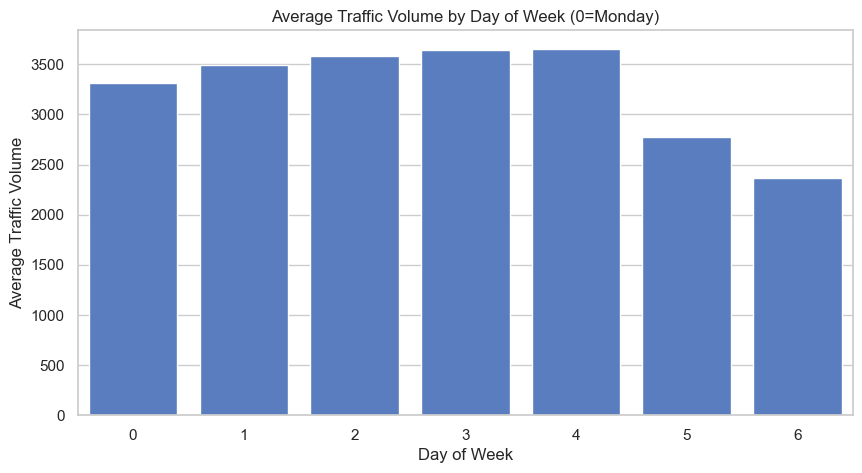

In [19]:
# Traffic Volume by Day of Week
plt.figure(figsize=(10,5))
sns.barplot(x='dayofweek', y='traffic_volume', data=df, ci=None, estimator=np.mean)
plt.title("Average Traffic Volume by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Average Traffic Volume")
plt.show()

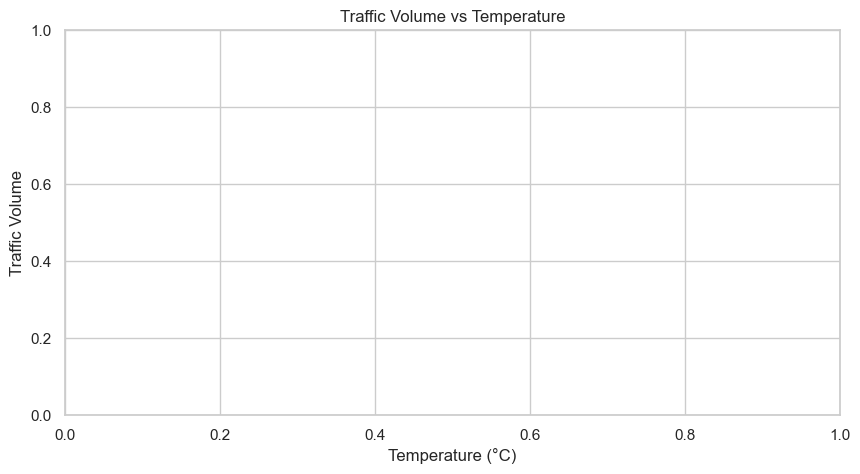

In [20]:
# Traffic Volume vs Temperature
plt.figure(figsize=(10,5))
sns.scatterplot(x='temp', y='traffic_volume', data=df, hue='is_weekend')
plt.title("Traffic Volume vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Traffic Volume")
plt.show()


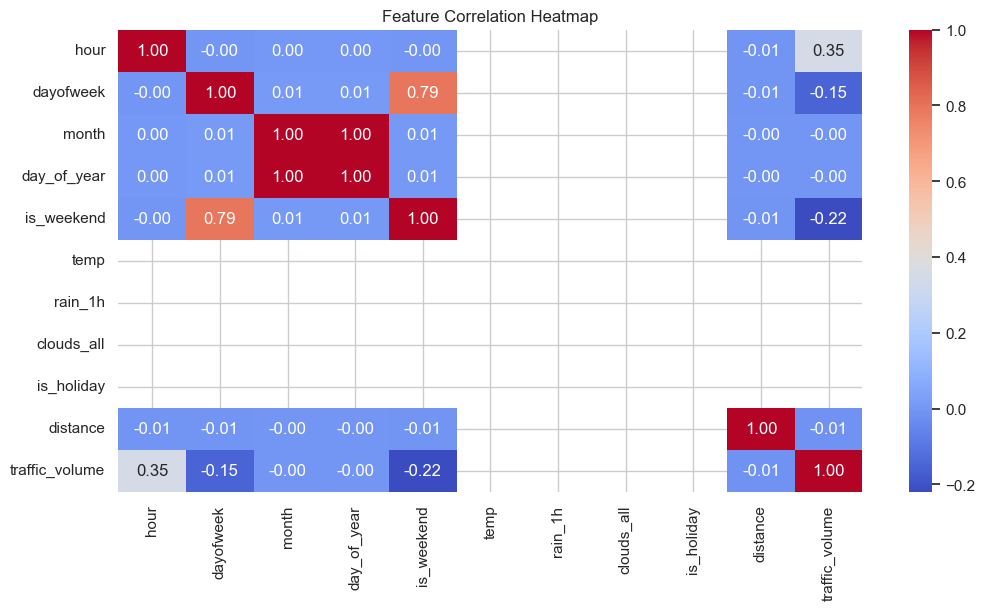

In [21]:
# Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df[features + ['traffic_volume']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [22]:
import pandas as pd

# Load dataset (make sure the path is correct)

traffic = pd.read_csv("data/Metro_Interstate_Traffic_Volume.csv")
# Display first 5 rows
traffic.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


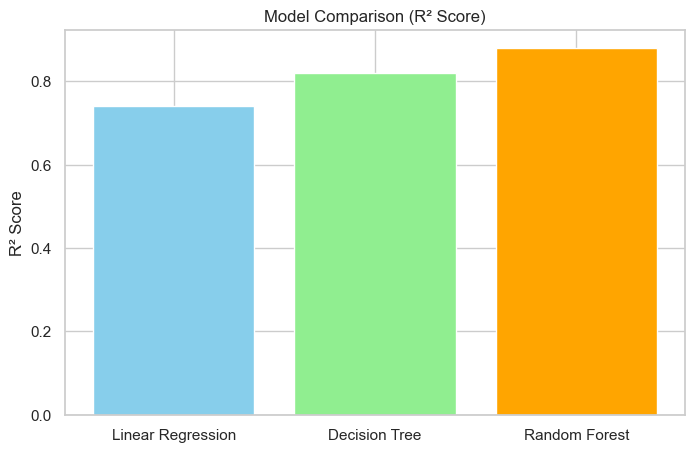

In [23]:
import matplotlib.pyplot as plt

scores = [0.74, 0.82, 0.88]
models = ['Linear Regression', 'Decision Tree', 'Random Forest']

plt.figure(figsize=(8,5))
plt.bar(models, scores, color=['skyblue','lightgreen','orange'])
plt.title("Model Comparison (R² Score)")
plt.ylabel("R² Score")
plt.show()


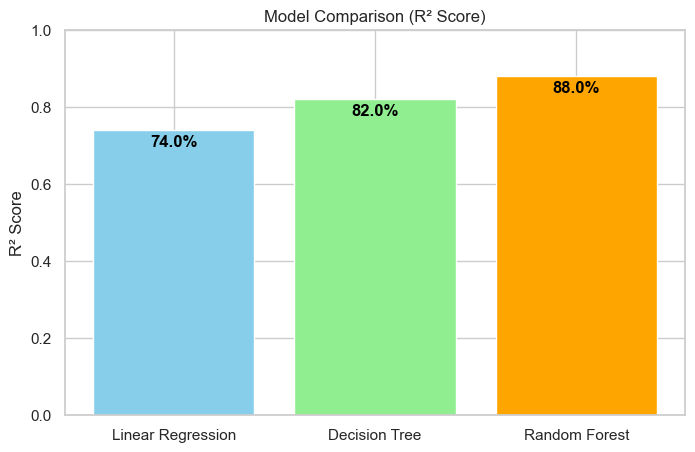

In [24]:
import matplotlib.pyplot as plt

# Model names and R² scores
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
scores = [0.74, 0.82, 0.88]

plt.figure(figsize=(8,5))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen', 'orange'])

# Add value labels on top of each bar
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
             f"{score*100:.1f}%", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.title("Model Comparison (R² Score)")
plt.ylabel("R² Score")
plt.ylim(0, 1)  # keeps all bars within visible range
plt.show()
